# Shell case study

__author__ = "Rahul Kakodkar"
__copyright__ = "Copyright 2023, Multi-parametric Optimization & Control Lab"
__credits__ = ["Rahul Kakodkar", Efstratios N. Pistikopoulos"]
__license__ = "MIT"
__version__ = "1.1.0"
__maintainer__ = "Rahul Kakodkar"
__email__ = "cacodcar@tamu.edu"
__status__ = "Production"


## Problem Statement

The hydrogen economy case study has been developed with the following considerations:

1. Green H2 supply chain (renewables, storage and an electrolyzer) that delivers 100 kta at a fixed production rate (at every time step, the same amount of hydrogen should be delivered)
2. For renewables, we compare the results of the supply chain using i) solar, ii) wind iii) hybrid solar+wind
3. We consider a single time period (2023 - 2030) 
4. We consider transportation (e.g. pipeline from Amarillo to Houston)
 
Also shown
- a table with the cost assumptions (CAPEX)
- the assumed full load hours of the location
- the installed capacities resulting from the optimization
- cost breakdown of the investment. 

Technologies considered:

1. Solar PV - Canadian Solar CS5P-220M with a ABB Micro Inverter
- Array performance model: California energy commission 
- Angle of incidence loss: Not considered
- Spectral loss: Not considered
- Temperature model: Open rack 

2. Wind Mill - Vestas V100/1800, 92m hub height
- Wind speed model: logarithmic,
- Density model: ideal_gas,
- Temperature model: linear_gradient
- Power output model: power_coefficient_curve
- Density correction: True
- Obstacle height: 0

3. PEM Electrolyzer - Hydrogenics bipolar PEM
- Rated production: 1Nm3/h
- Efficiency: 49.2%
- Specific energy consumption: 7.2 kWh/Nm3
- Hydrogen purity: 99.99%

4. Lithium-ion battery
- Coulombic efficiency: 95%
- Active Li material: graphite

5. Hydrogen compression 
- Compress to liquid

6. Pipeline transportation
- For liquified hydrogen


## Nomenclature



*Sets*


$\mathcal{R}$ - set of all resources r

$\mathcal{P}$ - set of all processes p

$\mathcal{T}$ - set of temporal periods t

$\mathcal{B}$ - set of transport modes b

$\mathcal{L}$ - set of locations l

$\mathcal{M}$ - set of materials m

*Subsets*


$\mathcal{R}^{storage}$ - set of resources that can be stored

$\mathcal{R}^{sell}$ - set of resources that can be discharged

$\mathcal{R}^{demand}$ - set of resources that meet  demand

$\mathcal{R}^{cons}$ - set of resources that can be consumed

$\mathcal{R}^{trans}$ - set of resources that can be transported

$\mathcal{P}^{uncertain}$ - set of processes with uncertain capacity

$\mathcal{T}^{net}$ - set of temporal periods t for network level decision making

$\mathcal{T}^{sch}$ - set of temporal periods t for schedule level decision making

*Continuous Variables*


$P_{l,p,t}$ - production level of p $\in$  $\mathcal{P}$ in time period t $\in$ $\mathcal{T}^{sch}$  

$C_{l,r,t}$ - consumption of r $\in$ in $\mathcal{R}^{cons}$ time period t $\in$ $\mathcal{T}^{sch}$ 

$S_{l,r,t}$ - discharge of r $\in$ in $\mathcal{R}^{demand}$ time period t $\in$ $\mathcal{T}^{sch}$ 

$Inv_{l,r,t}$ - inventory level of r $\in$ $\mathcal{R}^{storage}$  in time period t $\in$ $\mathcal{T}^{sch}$

$Cap^S_{l,r,t}$ - installed inventory capacity for resource r $\in$  $\mathcal{R}^{storage}$ in time period t $\in$ $\mathcal{T}^{net}$

$Cap^P_{l,p,t}$ - installed production capacity for process p $\in$ $\mathcal{P}$ in time period t $\in$ $\mathcal{T}^{net}$

$Mat^P_{l,p,m,t}$ - material m $\in$ $\mathcal{M}$ used by process p $\in$ $\mathcal{P}$ in time period t $\in$ $\mathcal{T}^{net}$

$Em^{p/r/m}_{l,p/r/m,t}$ - emission from process/resource/material in time t $\in$ $\mathcal{T}^{net}$


*Binary Variables*

$X^P_{l,p,t}$ - network binary for production process p $\in$ $\mathcal{P}$

$X^S_{l,r,t}$ - network binary for inventory of resource r $\in$  $\mathcal{R}^{storage}$ 

*Parameters*

$Cap^{P-max}_{l,p,t}$ - maximum production capacity of process p $\in$ $\mathcal{P}$ in time t $\in$ $\mathcal{T}^{net}$

$Cap^{S-max}_{l,r,t}$ - maximum inventory capacity for process r $\in$ $\mathcal{R}^{storage}$ in time t $\in$ $\mathcal{T}^{net}$

$Capex_{l,p,t}$ - capital expenditure for process p $\in$ $\mathcal{P}$ in time t $\in$ $\mathcal{T}^{net}$

$Vopex_{l,p,t}$ - variable operational expenditure for process p $\in$ $\mathcal{P}$ in time t $\in$ $\mathcal{T}^{sch}$

$Price_{l,r,t}$ - purchase price for resource r $\in$ $\mathcal{R}^{cons}$ in time t $\in$ $\mathcal{T}^{sch}$

$C^{max}_{l,r,t}$ - maximum consumption availability for resource r $\in$ $\mathcal{R}^{cons}$ in time t $\in$ $\mathcal{T}^{sch}$

$D_{l,r,t}$ - demand for resource r $in$ $\mathcal{R}^{sell}$ in time t $\in$ $\mathcal{T}^{sch}$

$\alpha$ - annualization factor

$Mat^{cons}_{p,m}$ - material m $\in$ $\mathcal{M}$ consumed by process p $\in$ $\mathcal{P}$

$GWP^{p/r/m}_{l,p/r/m,t}$ - global warming indicators for process/resource/material in time t $\in$ $\mathcal{T}^{net}$


## MILP Formulation

Given is a mulit-scale modeling and optimization MILP framework for the simultaneous design and schedule planning of a single location energy system 

\begin{equation}
    min \sum_{l \in \mathcal{L}} \Big(\sum_{t \in \mathcal{T}^{net}} \sum_{p \in \mathcal{P}} (\alpha \times Capex_{l,p,t} + Fopex_{l,p,t}) \times Cap^P_{l,p,t} +  \sum_{t \in \mathcal{T}^{sch}} \sum_{r \in \mathcal{R}}  Vopex_{l,r,t} \times P_{l,r,t} 
\end{equation}

\begin{equation*}
    + \sum_{t \in \mathcal{T}^{sch}} \sum_{r \in \mathcal{R}^{cons}} C_{l,r,t} \times Price_{l,r,t} \Big)
\end{equation*}

\begin{equation}
    Cap^S_{l,r,t} \leq Cap^{S-max}_{l,r,t} \times X^S_{l,r,t} \hspace{1cm} \forall r \in \mathcal{R}^{storage}, t \in \mathcal{T}^{net}
\end{equation}

\begin{equation}
    Cap^P_{l,p,t} \leq Cap^{P-max}_{l,p,t} \times X^P_{l,p,t}  \hspace{1cm} \forall p \in \mathcal{P}, t \in \mathcal{T}^{net}, l \in \mathcal{L}
\end{equation} 

\begin{equation}
    P_{l,p,t} \leq Cap^{P}_{l,p,t}  \hspace{1cm} \forall p \in \mathcal{P}, t \in \mathcal{T}^{sch}
\end{equation} 

\begin{equation}
    Inv_{l,r,t} \leq Cap^{S}_{l,r,t}  \hspace{1cm} \forall r \in \mathcal{R}^{storage}, t \in \mathcal{T}^{sch}
\end{equation} 


\begin{equation}
    - S_{l,r,t} \leq - D_{l,r,t}  \hspace{1cm} \forall r \in \mathcal{R}, t \in \mathcal{T}^{sch}
\end{equation}

\begin{equation}
    C_{l,r,t} \leq C^{max}_{l,r,t} \hspace{1cm} \forall r \in \mathcal{R}, t \in \mathcal{T}^{sch}
\end{equation}

\begin{equation}
    \sum_{p \in \mathcal{P}} P_{l,p,t} \times \eta(p,r) + C_{l,r,t} +  Inv_{l,r,t-1}=  Inv_{l,r,t} + S_{l,r,t}  
\end{equation}

\begin{equation*}
    \forall r \in \mathcal{R}^{cons}, t \in \mathcal{T}^{sch}, l \in \mathcal{L}
\end{equation*}

\begin{equation}
    Mat_{l,p,m,t} = Mat^{cons}_{p,m} \times Cap^P_{l,p,t} \hspace{1cm} \forall m \in \mathcal{M}, p \in \mathcal{P}, t \in \mathcal{T}^{net}
\end{equation}

\begin{equation}
    Em^{r}_{l,r,t} = GWP^{r}_{l,r,t} \times C_{l,r,t} \hspace{1cm} \forall r \in \mathcal{R}, t \in \mathcal{T}^{sch}
\end{equation}

\begin{equation}
    Em^{m}_{l,m,t} = GWP^{m}_{l,m,t} \times \sum_{p \in \mathcal{P}} Mat_{l,p,m,t} \hspace{1cm} \forall p \in \mathcal{P}, t \in \mathcal{T}^{net}
\end{equation}

\begin{equation}
    Em^{p}_{l,p,t} = GWP^{p}_{l,p,t} \times Cap_{l,p,t} \hspace{1cm} \forall p \in \mathcal{P}, t \in \mathcal{T}^{net}
\end{equation}

\begin{equation}
    S_{l,r,t}, C_{l,r,t}, Inv_{l,r,t}, P_{l,p,t}, Cap^P_{l,p,t}, Cap^S_{l,r,t}, Mat_{l,p,m,t}, Em^{p/r/m}_{l,p/r/m,t} \in R_{\geq 0}
\end{equation}



## Import Modules

In [1]:
import sys
sys.path.append('../../src')

In [2]:

import pandas
import numpy
from energiapy.components.temporal_scale import TemporalScale
from energiapy.components.resource import Resource, VaryingResource
from energiapy.components.process import Process, VaryingProcess
from energiapy.components.material import Material
from energiapy.components.location import Location
from energiapy.components.network import Network
from energiapy.components.scenario import Scenario
from energiapy.components.transport import Transport
from energiapy.model.formulate import formulate, Constraints, Objective
from energiapy.utils.nsrdb_utils import fetch_nsrdb_data
from energiapy.plot import plot_results, plot_scenario
from energiapy.plot.plot_results import CostY, CostX
from energiapy.model.solve import solve
from itertools import product
import matplotlib.pyplot as plt 
from energiapy.conversion.photovoltaic import solar_power_output
from energiapy.conversion.windmill import wind_power_output

## Data Import

The following data is needed for the model

- solar and wind profiles : energiapy.fetch_nsrdb_data imports data from the NREL NSRDB database
- power demand : ERCOT for Houston


In [3]:
# weather_houston = pandas.concat([fetch_nsrdb_data(attrs=['dni', 'dhi', 'wind_speed', 'ghi', 'air_temperature', 'dew_point', 'relative_humidity', 'surface_pressure'], year=2016+i, state='Texas',
#                                    county='Harris', resolution='hourly', get='min-elevation')[1] for i in range(5)])
# weather_houston.index = pandas.to_datetime(weather_houston.index, utc = True)
# weather_houston.index = weather_houston.index.strftime('%m/%d/%Y, %r')
# weather_houston = weather_houston[~weather_houston.index.str.contains('02/29')]


In [6]:
coord_houston = (29.56999969482422, -95.05999755859375)
weather_houston = pandas.read_csv('../data/weather_houston.csv', index_col= 0)
weather_houston.index = pandas.to_datetime(weather_houston.index)

**Get Weather data**

In [7]:
solar = solar_power_output(data= weather_houston, coord=coord_houston)

In [8]:
wind = wind_power_output(data= weather_houston)

## Define temporal scale


The variabilities of energy systems are best captured over a discretized spatio-temporal scale. In energiapy, the first declaration is the temporal scale. 

For e.g.: Here we declare three temporal scales at different levels from right to left. The interpretation of these scales is merely symentic. Scales can be declared as the problem demands.
- 0, annual, with 1 discretization
- 1, daily with 365 discretization 
- 2, hourly with 24 discretization

In essence, we are creating a temporal scale of 8760 points.

The demand is met on a daily basis

In [9]:
scales = TemporalScale(discretization_list=[5, 365, 24])

## Declare resources

Resources can be consumed, produced, stored, discharged (or sold).

Power demand follows a varying deterministic demand

In [10]:
bigM = 10**5
smallM = 10

In [11]:
Solar = Resource(name='Solar', cons_max=100, basis='MW', label='Solar Power')

Wind = Resource(name='Wind', cons_max=100, basis='MW', label='Wind Power')

Power = Resource(name='Power', basis='MW', label='Power generated')

H2 = Resource(name='H2', basis='tons', label='Hydrogen', demand=True)

O2 = Resource(name='O2', basis='tons', label='Oxygen', sell= True)

H2O = Resource(name='H2O', cons_max=100, price=0.001, basis='tons')

## Declare Processes

In [12]:
PEM = Process(name='PEM', conversion={Power: -1, H2: 0.3537, O2: 2.8302, H2O: -3.1839}, capex=1.55*10**6, fopex=0,
              vopex=0, prod_max=100, prod_min = 0.1, basis = 'tons', label = 'PEM' )

LiI = Process(name='LiI', storage=Power, capex=1302182, fopex=41432, vopex=2000,
              prod_max=100, prod_min=0, store_max=100, label='Lithium-ion battery', basis='MW')

WF = Process(name='WF', conversion={Wind: -1, Power: 1}, capex=1462000, fopex=43000, vopex=4953, land = 10800/1800,
             prod_max=100, prod_min=0, label='Wind mill array', varying=[VaryingProcess.DETERMINISTIC_CAPACITY], basis='MW')

PV = Process(name='PV', conversion={Solar: -1, Power: 1}, capex=1333262, fopex=22623, vopex=0,  land = 10000/1800,
             prod_max=100, prod_min=0,  varying= [VaryingProcess.DETERMINISTIC_CAPACITY], label='Solar PV', basis='MW')

## Declare Location

In [13]:
houston = Location(name='HO', processes={LiI, PV, WF, PEM}, capacity_factor={PV: solar, WF: wind}, scales=scales, label='Houston', demand_scale_level=1, capacity_scale_level=2)

## Declare Scenario

In [14]:

scenario = Scenario(name='scenario_full', network=houston, scales=scales,  expenditure_scale_level=0, scheduling_scale_level=2,
                    network_scale_level=0, demand_scale_level=1, label='full_case', demand={houston: {H2: 0.2740}}, annualization_factor = 0.15)


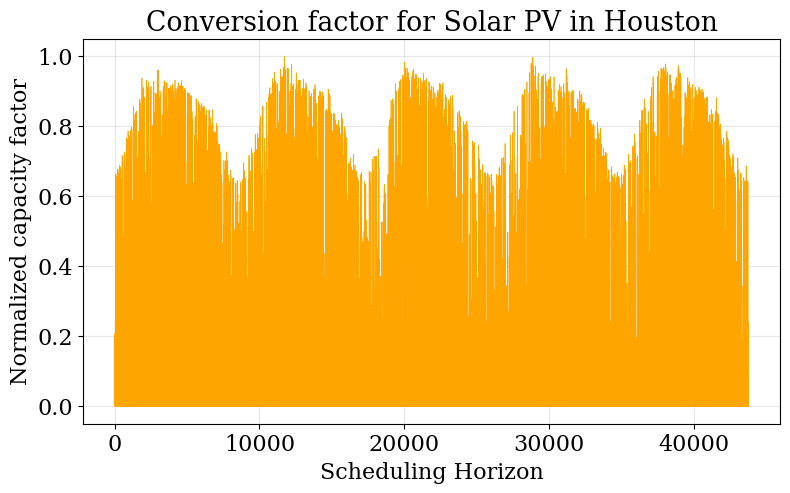

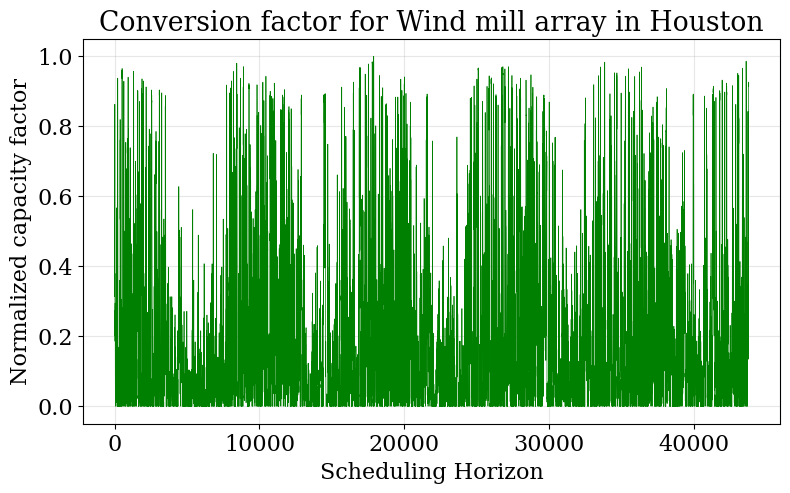

In [13]:
plot_scenario.capacity_factor(
    scenario=scenario, location=houston, process=PV, fig_size=(9, 5), color='orange')
plot_scenario.capacity_factor(
    scenario=scenario, location=houston, process=WF, fig_size=(9, 5), color='green')


## Formulate MILP

Here we formulate two milps which differ only in their objectives.

For maximizing the discharge of a particular resource, use the objective MAX_DISCHARGE, the objective resource also needs to be specified.

Similarly the discharge can also be minimized using MIN_DISCHARGE. This can be used with a demand for another resource being set. For example, minimizing the discharge of carbon dioxide while meeting a hydrogen demand.

The second MILP, minimized the cost while meeting a varying demand for power

## Optimize to maximize resource discharge

In [14]:

# milp_demand = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION, Constraints.RESOURCE_BALANCE,
#                         Constraints.NETWORK, Constraints.LAND}, objective=Objective.MAX_DISCHARGE, write_lpfile=True, objective_resource=H2)


In [15]:
# results_demand = solve(scenario=scenario, instance=milp_demand, solver='gurobi', name="results_demand", print_solversteps=True)


## Optimize to minimize cost

In [16]:
milp_cost = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY,
                      Constraints.PRODUCTION, Constraints.RESOURCE_BALANCE, Constraints.NETWORK}, objective=Objective.COST)

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint location capex
constraint location fopex
constraint location vopex
constraint location incidental
constraint network capex
constraint network fopex
constraint network vopex
constraint network incidental
constraint nameplate inventory
constraint storage max
constraint storage min
constraint production mode
constraint nameplate production
constraint production max
constraint production min
constraint inventory balance
constraint resource consumption
constraint resource purchase
constraint location production
constraint location discharge
constraint location consumption
constraint location purchase
constraint network production
constraint network discharge
constraint network consumption
constraint network purchase
constraint storage facility
constraint production facility
constraint min production facility
constraint min storage facility
constraint demand
objective cost


In [17]:
results_cost = solve(scenario=scenario, instance=milp_cost,
                     solver='gurobi', name=f"results_cost", print_solversteps=True)

Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6700 CPU @ 3.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1053385 rows, 920151 columns and 4963398 nonzeros
Model fingerprint: 0xd528549e
Variable types: 920121 continuous, 30 integer (30 binary)
Coefficient statistics:
  Matrix range     [2e-05, 2e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-01, 1e+02]
Presolve removed 837248 rows and 705820 columns
Presolve time: 2.54s
Presolved: 216137 rows, 214331 columns, 642950 nonzeros
Variable types: 214331 continuous, 0 integer (0 binary)
Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Root barrier log...

Ordering time: 0.08s

Barrier statistics:
 Dense cols : 20
 AA' NZ     : 4.684e+05
 Factor NZ  : 2.948e+06 (roughly 

In [18]:
results_cost.output['objective']/(1000* results_cost.output['S_network']['H2', 0])

77.8889520056922

In [19]:
results_cost.output['S_network']['H2', 0]

500.05000000000007

In [20]:
milp_cost.constraint_process_capex.pprint()

constraint_process_capex : total purchase from network
    Size=25, Index=constraint_process_capex_index, Active=True
    Key                        : Lower : Body                                               : Upper : Active
              ('HO', 'LiI', 0) :   0.0 : Capex_process[HO,LiI,0] - 195327.3*Cap_P[HO,LiI,0] :   0.0 :   True
              ('HO', 'LiI', 1) :   0.0 : Capex_process[HO,LiI,1] - 195327.3*Cap_P[HO,LiI,1] :   0.0 :   True
              ('HO', 'LiI', 2) :   0.0 : Capex_process[HO,LiI,2] - 195327.3*Cap_P[HO,LiI,2] :   0.0 :   True
              ('HO', 'LiI', 3) :   0.0 : Capex_process[HO,LiI,3] - 195327.3*Cap_P[HO,LiI,3] :   0.0 :   True
              ('HO', 'LiI', 4) :   0.0 : Capex_process[HO,LiI,4] - 195327.3*Cap_P[HO,LiI,4] :   0.0 :   True
    ('HO', 'LiI_discharge', 0) :   0.0 :                  Capex_process[HO,LiI_discharge,0] :   0.0 :   True
    ('HO', 'LiI_discharge', 1) :   0.0 :                  Capex_process[HO,LiI_discharge,1] :   0.0 :   True
    ('HO',

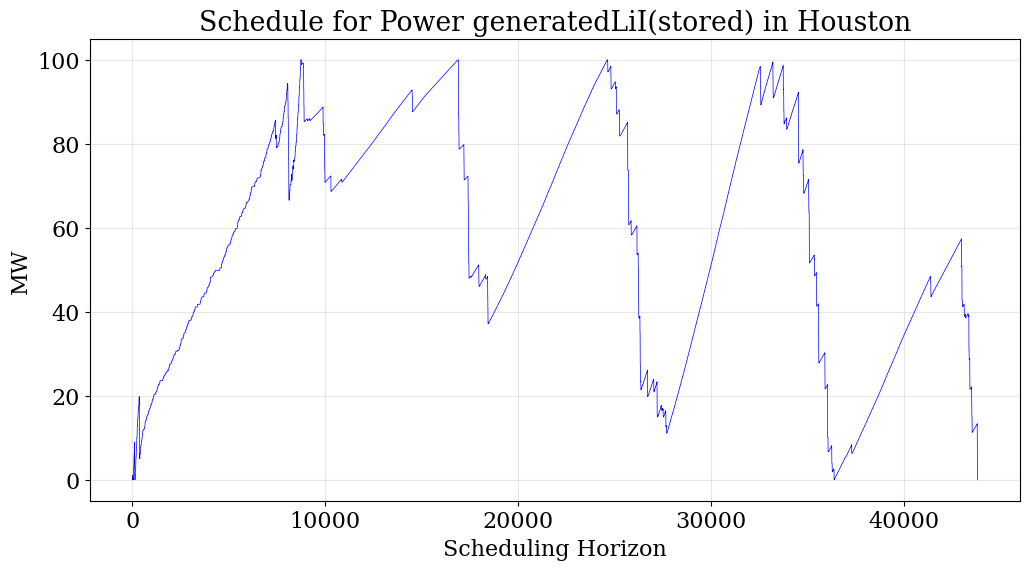

In [21]:
plot_results.schedule(results=results_cost, y_axis='Inv',
                      component='LiI_Power_stored', location='HO')
# plot_results.schedule(results=results_cost, y_axis='Inv',
#                       component='LiI_Ro_Power_stored', location='HO')


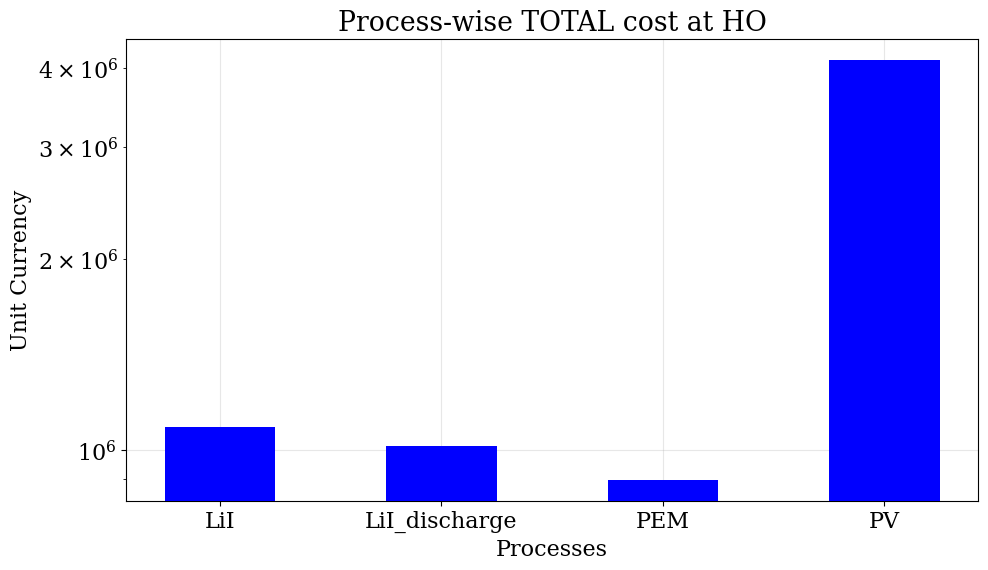

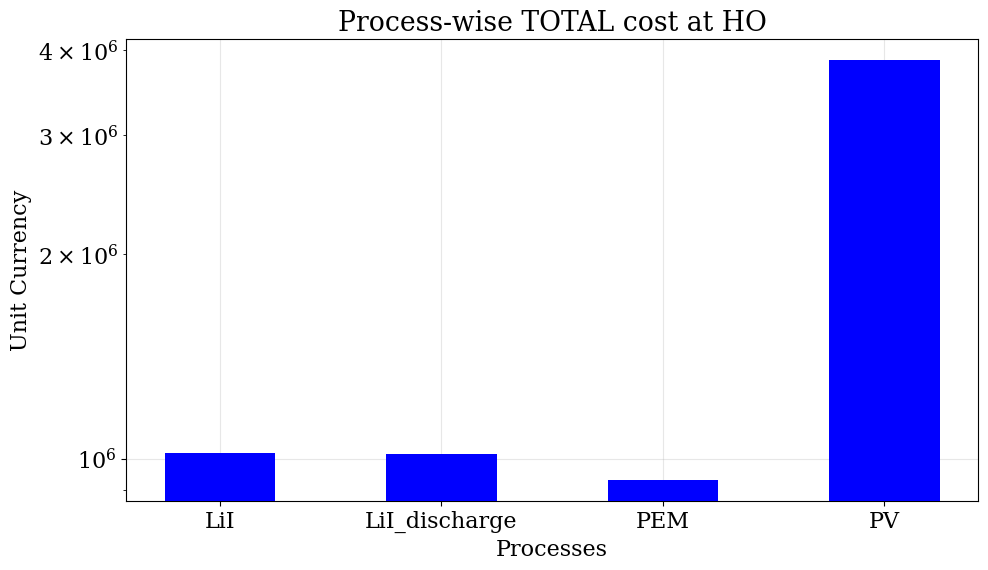

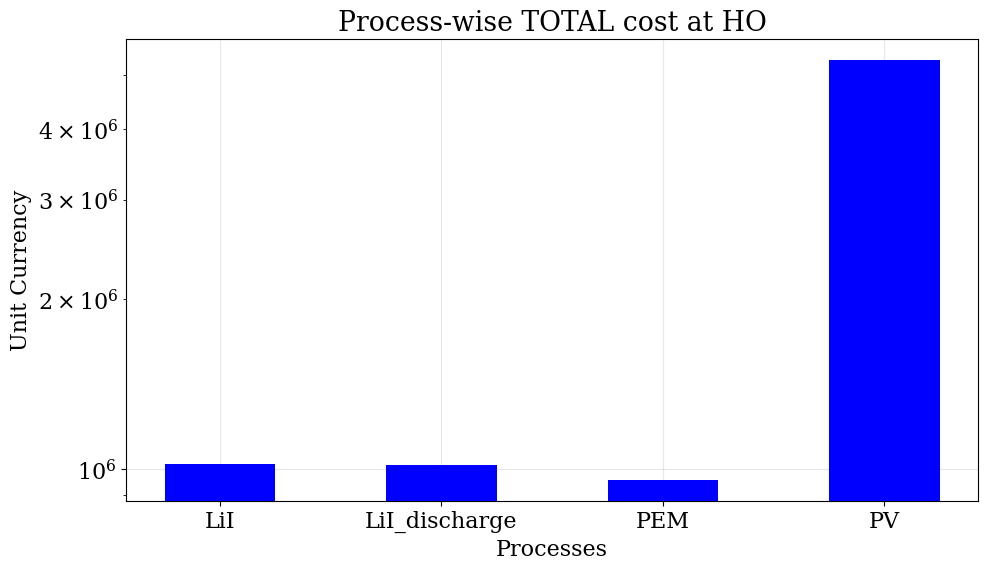

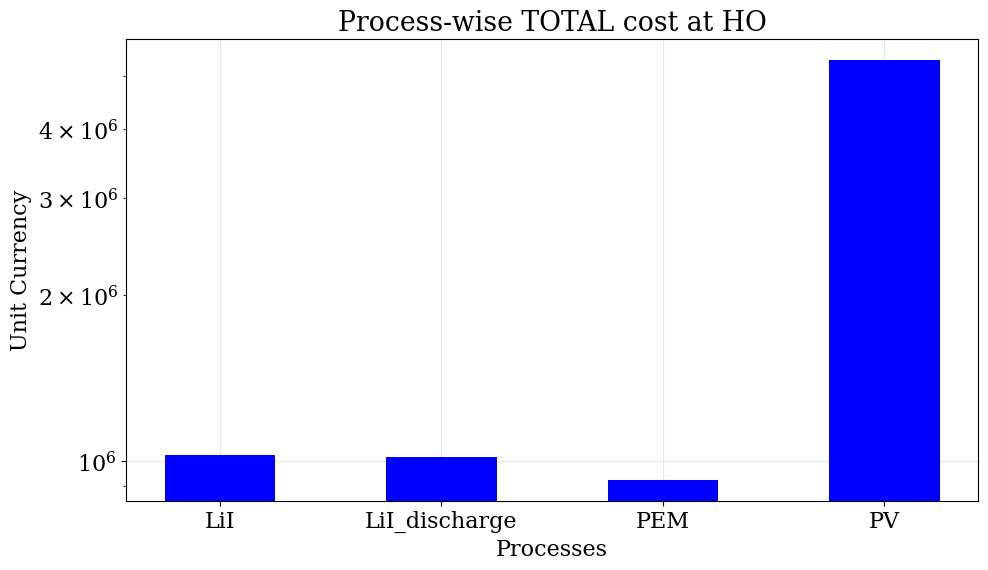

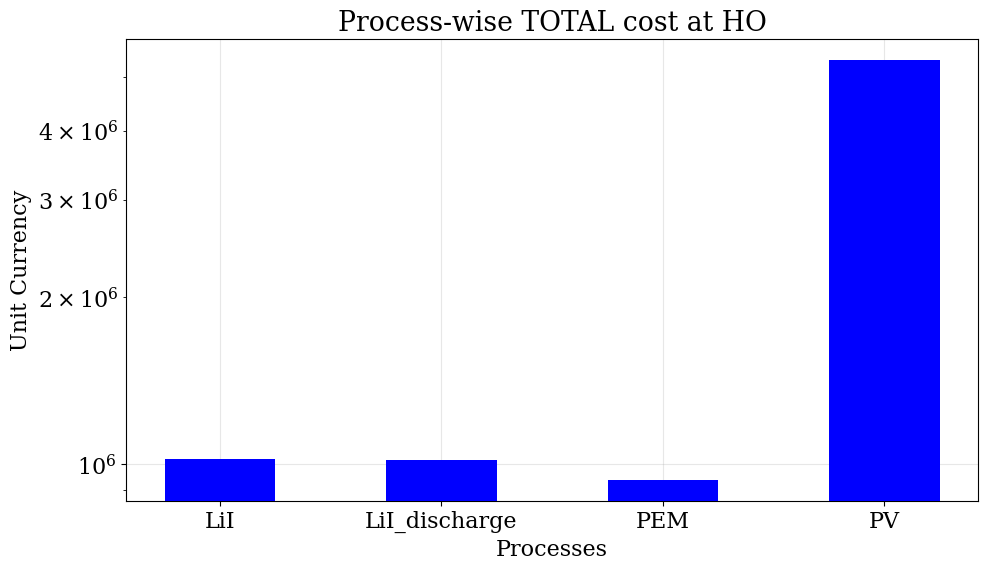

In [22]:
for i in range(5):
    plot_results.cost(results=results_cost, x=CostX.PROCESS_WISE, 
                    y=CostY.TOTAL, network_scale_period=i, location='HO', fig_size=(11, 6))


# plot_results.cost(results=results_cost, x=CostX.LOCATION_WISE,
#                   y=CostY.TOTAL,  network_scale_period=2, location='HO', fig_size=(11, 6))

In [23]:
results_cost.output['Cap_P']

{('HO', 'LiI', 0): 0.29806719202705945,
 ('HO', 'LiI', 1): 0.011086229285659102,
 ('HO', 'LiI', 2): 0.019521384392449524,
 ('HO', 'LiI', 3): 0.033791259284010125,
 ('HO', 'LiI', 4): 0.018896333215414295,
 ('HO', 'LiI_discharge', 0): 100.0,
 ('HO', 'LiI_discharge', 1): 100.0,
 ('HO', 'LiI_discharge', 2): 100.0,
 ('HO', 'LiI_discharge', 3): 100.0,
 ('HO', 'LiI_discharge', 4): 100.0,
 ('HO', 'PEM', 0): 3.867506184961174,
 ('HO', 'PEM', 1): 4.006709810337085,
 ('HO', 'PEM', 2): 4.118692416267526,
 ('HO', 'PEM', 3): 3.9828282067099665,
 ('HO', 'PEM', 4): 4.036933267979362,
 ('HO', 'PV', 0): 18.534682413610795,
 ('HO', 'PV', 1): 17.398554756346048,
 ('HO', 'PV', 2): 23.873554772297748,
 ('HO', 'PV', 3): 24.011877845084737,
 ('HO', 'PV', 4): 24.132163247932247,
 ('HO', 'WF', 0): 0.0,
 ('HO', 'WF', 1): 0.0,
 ('HO', 'WF', 2): 0.0,
 ('HO', 'WF', 3): 0.0,
 ('HO', 'WF', 4): 0.0}

In [24]:
results_cost.output['X_P']

{('HO', 'LiI', 0): 1.0,
 ('HO', 'LiI', 1): 1.0,
 ('HO', 'LiI', 2): 1.0,
 ('HO', 'LiI', 3): 1.0,
 ('HO', 'LiI', 4): 1.0,
 ('HO', 'LiI_discharge', 0): 1.0,
 ('HO', 'LiI_discharge', 1): 1.0,
 ('HO', 'LiI_discharge', 2): 1.0,
 ('HO', 'LiI_discharge', 3): 1.0,
 ('HO', 'LiI_discharge', 4): 1.0,
 ('HO', 'PEM', 0): 1.0,
 ('HO', 'PEM', 1): 1.0,
 ('HO', 'PEM', 2): 1.0,
 ('HO', 'PEM', 3): 1.0,
 ('HO', 'PEM', 4): 1.0,
 ('HO', 'PV', 0): 1.0,
 ('HO', 'PV', 1): 1.0,
 ('HO', 'PV', 2): 1.0,
 ('HO', 'PV', 3): 1.0,
 ('HO', 'PV', 4): 1.0,
 ('HO', 'WF', 0): 1.0,
 ('HO', 'WF', 1): 1.0,
 ('HO', 'WF', 2): 1.0,
 ('HO', 'WF', 3): 1.0,
 ('HO', 'WF', 4): 1.0}

In [25]:
total_cost = {i:results_cost.output['Capex_process'][i] + results_cost.output['Vopex_process'][i] + results_cost.output['Fopex_process'][i] for  i in results_cost.output['Capex_process'].keys()}

In [26]:
total_cost

{('HO', 'LiI', 0): 1087962.966766163,
 ('HO', 'LiI', 1): 1020017.5549141829,
 ('HO', 'LiI', 2): 1022014.6563326581,
 ('HO', 'LiI', 3): 1025393.1819230715,
 ('HO', 'LiI', 4): 1021866.669653519,
 ('HO', 'LiI_discharge', 0): 1017392.7870288994,
 ('HO', 'LiI_discharge', 1): 1017392.7870288994,
 ('HO', 'LiI_discharge', 2): 1017392.7870288994,
 ('HO', 'LiI_discharge', 3): 1017392.7870288994,
 ('HO', 'LiI_discharge', 4): 1017392.7870288994,
 ('HO', 'PEM', 0): 899195.188003473,
 ('HO', 'PEM', 1): 931560.0309033723,
 ('HO', 'PEM', 2): 957595.9867821997,
 ('HO', 'PEM', 3): 926007.5580600672,
 ('HO', 'PEM', 4): 938586.9848052016,
 ('HO', 'PV', 0): 4126048.2818634505,
 ('HO', 'PV', 1): 3873132.290986133,
 ('HO', 'PV', 2): 5314546.937037177,
 ('HO', 'PV', 3): 5345339.354413357,
 ('HO', 'PV', 4): 5372116.364597668,
 ('HO', 'WF', 0): 0.0,
 ('HO', 'WF', 1): 0.0,
 ('HO', 'WF', 2): 0.0,
 ('HO', 'WF', 3): 0.0,
 ('HO', 'WF', 4): 0.0}

In [27]:
results_cost.output['Capex_process']

{('HO', 'LiI', 0): 58220.659837227046,
 ('HO', 'LiI', 1): 2165.443233548721,
 ('HO', 'LiI', 2): 3813.0593056393054,
 ('HO', 'LiI', 3): 6600.35543954563,
 ('HO', 'LiI', 4): 3690.9697468671925,
 ('HO', 'LiI_discharge', 0): 0.0,
 ('HO', 'LiI_discharge', 1): 0.0,
 ('HO', 'LiI_discharge', 2): 0.0,
 ('HO', 'LiI_discharge', 3): 0.0,
 ('HO', 'LiI_discharge', 4): 0.0,
 ('HO', 'PEM', 0): 899195.188003473,
 ('HO', 'PEM', 1): 931560.0309033723,
 ('HO', 'PEM', 2): 957595.9867821997,
 ('HO', 'PEM', 3): 926007.5580600672,
 ('HO', 'PEM', 4): 938586.9848052016,
 ('HO', 'PV', 0): 3706738.1616203333,
 ('HO', 'PV', 1): 3479524.7867333163,
 ('HO', 'PV', 2): 4774455.507423486,
 ('HO', 'PV', 3): 4802118.641924005,
 ('HO', 'PV', 4): 4826174.435439697,
 ('HO', 'WF', 0): 0.0,
 ('HO', 'WF', 1): 0.0,
 ('HO', 'WF', 2): 0.0,
 ('HO', 'WF', 3): 0.0,
 ('HO', 'WF', 4): 0.0}